In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score,f1_score,roc_curve,auc
import math
from sklearn.feature_selection import SelectFromModel
from joblib import dump
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import json

with open('env_variables.json', 'r') as file:
    variable_to_store = json.load(file)

Model_Selected=(variable_to_store['Model_Selected'])

In [5]:
print("\033[1m"+"Starting Prescriptive Model BUilding using:"+"\033[0m" ,Model_Selected)
df=pd.read_csv("processed_data.csv")

Starting Prescriptive Model BUilding using: Random Forest


In [6]:
df['model_group'] = df['Account_Nature'].astype(str) + '-' + df['Type'].astype(str) + '-' + df['Sector'].astype(str)

In [7]:
model_group = df['model_group']

In [8]:
import numpy as np
import pandas as pd


np.random.seed(0)


distribution_percents_no = {
    'SMS': 0.25,
    'Calling': 0.25,
    'Notice': 0.25,
    'Direct_Visit': 0.25
}

distribution_percents_yes = {
    'SMS': 0.25,
    'Calling': 0.25,
    'Notice': 0.25,
    'Direct_Visit': 0.25
}


df_delinquent_no = df[df['Delinquent'] == 'No'].copy()
df_delinquent_yes = df[df['Delinquent'] == 'Yes'].copy()

# assign actions based on distribution
def assign_actions(df, distribution_percents):
    total_count = len(df)
    action_counts = {action: int(percent * total_count) for action, percent in distribution_percents.items()}

    # rounding errors
    while sum(action_counts.values()) != total_count:
        action = np.random.choice(list(distribution_percents.keys()))
        action_counts[action] += total_count - sum(action_counts.values())

  
    actions = np.concatenate([[action] * count for action, count in action_counts.items()])

    # Assign actions
    for idx, action in zip(df.index, actions):
        df.loc[idx, 'Assigned_Action'] = action

   
    for action in distribution_percents.keys():
        df.loc[:, action] = np.where(df['Assigned_Action'] == action, 1, 0)

    return df


df_delinquent_no = assign_actions(df_delinquent_no, distribution_percents_no)
df_delinquent_yes = assign_actions(df_delinquent_yes, distribution_percents_yes)

# Combine the two dataframes
df_combined = pd.concat([df_delinquent_no, df_delinquent_yes])


df_combined.drop('Assigned_Action', axis=1, inplace=True)


In [9]:
df_combined.to_csv("z12.csv")

In [10]:
print("\033[1m"+"After Adding OMS data"+"\033[0m")
df_combined.head


After Adding OMS data


<bound method NDFrame.head of              Age   Customer_Type  Gender    Location         Income  \
0      46.538302  Non Individual  Female       Metro  632822.910588   
1      55.189847  Non Individual   Other       Metro  126753.320336   
2      49.343696  Non Individual    Male       Urban  418274.601330   
3      46.333926  Non Individual   Other  Semi Urban  628808.525461   
4      40.030050  Non Individual    Male       Rural  565948.324664   
...          ...             ...     ...         ...            ...   
99983  47.624516  Non Individual  Female       Metro  825273.141167   
99984  60.659665      Individual  Female       Urban  469533.684615   
99990  33.207058  Non Individual    Male       Urban  964172.231166   
99997  60.126908      Individual   Other       Metro  380327.714458   
99999  29.739305      Individual  Female       Urban  438709.640745   

         Occupation Type_of_Profession  Credit_Score  Number_of_Products  \
0          Salaried       Professional   

In [11]:
print("\033[1m"+"Uplift Modelling using OMS data"+"\033[0m")
df_d = df_combined.drop(['Age', 'Income', 'Credit_Score', 'Number_of_Products', 'Tenure_of_Association', 
                'Min_Avg_Balance', 'Last_FY_Credit', 'Last_Account_Opened', 'Balance', 
                'Security_Amount', 'Loan_Repayment_Amount', 'Rate_of_Interest', 
                'Loan_Disbursed_Amount', 'NEG_MAB_CORR', 'MAB_CORR', 'SMA_DAYS', 
                'NPA_TO_STD', 'STD_TO_NPA', 'BOUNCE_RATE', 'AVG_WDL', 'prd', 'Type', 
                'Sector', 'Sub_sector', 'Product', 'model_group'], axis=1)

Uplift Modelling using OMS data


In [12]:
df_dummies = pd.get_dummies(df_d)

# Reattach 'model_group'
df_dummies['model_group'] = model_group

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np


actions = ['SMS', 'Calling', 'Notice', 'Direct_Visit']


all_groups_data = []


for group, group_df in df_dummies.groupby('model_group'):
   
    X = group_df.drop(['Delinquent_No', 'Delinquent_Yes', 'model_group'], axis=1)
    y = group_df['Delinquent_Yes']

    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

   
    if(Model_Selected=='Logistic Regression'):
        rf_model = LogisticRegression(max_iter=1000)
        rf_model.fit(X_train, y_train)
    else:
        rf_model = RandomForestClassifier(random_state=42)
        rf_model.fit(X_train, y_train)

    
    original_X_test = X_test.copy()

    # Prepare baseline data (all actions set to 0)
    X_test_baseline = original_X_test.copy()
    for action in actions:
        X_test_baseline[action] = 0
    baseline_pred = rf_model.predict_proba(X_test_baseline)[:, 1]  

    # Dictionary to store predictions and uplift for each action
    predictions = {}
    uplifts = {action: [] for action in actions}

    # Create a copy of the original X_test with current action set to 1 and others to 0
    for action in actions:
        
        X_test_action = original_X_test.copy()
        for a in actions:
            X_test_action[a] = 1 if a == action else 0

        
        action_pred = rf_model.predict_proba(X_test_action)[:, 1]  # Assuming positive class at index 1
        predictions[action] = action_pred

        # Calculate uplift 
        for i in range(len(baseline_pred)):
            if baseline_pred[i] > 0:
                uplift = 100 * (baseline_pred[i] - action_pred[i]) / baseline_pred[i]
            else:
                uplift = 0  # Avoid division by zero
            uplifts[action].append(uplift)

    # Determine the best action
    best_actions = []
    for i in range(len(original_X_test)):
        best_action = 'none'
        highest_uplift = -np.inf  

        for action in actions:
            if uplifts[action][i] > highest_uplift:
                highest_uplift = uplifts[action][i]
                best_action = action

        best_actions.append(best_action)

    # Add the best actions, uplifts, and predictions to the original test data
    original_X_test['best_action'] = best_actions
    original_X_test['baseline_pred'] = baseline_pred
    for action in actions:
        original_X_test[f'uplift_{action}'] = uplifts[action]
        original_X_test[f'pred_{action}'] = predictions[action]

    
    all_groups_data.append(original_X_test)


final_df = pd.concat(all_groups_data)


final_df.to_csv('final_oms_data.csv')


In [14]:
print("\033[1m"+"Risk Categorization"+"\033[0m")
def categorize_risk(pred):
    if pred <= 0.4:
        return 'Low Risk'
    elif pred <= 0.6:
        return 'Medium Risk'
    else:
        return 'High Risk'

# Assuming final_df is your final DataFrame that includes the 'baseline_pred' column
final_df['risk_category'] = final_df['baseline_pred'].apply(categorize_risk)

Risk Categorization


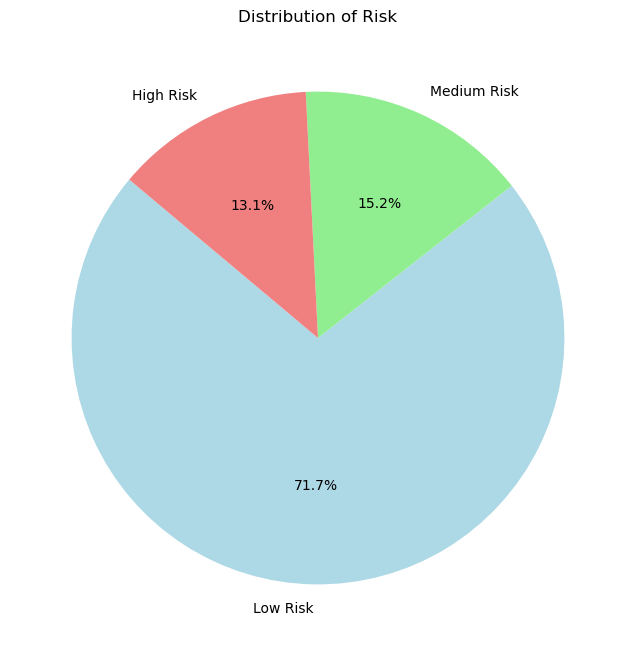

In [15]:
# Data preparation for pie chart
best_action_counts = final_df['risk_category'].value_counts()

# Create pie chart for distribution of best actions
plt.figure(figsize=(8, 8))
plt.pie(best_action_counts, labels=best_action_counts.index, autopct='%1.1f%%', startangle=140, colors=['lightblue', 'lightgreen', 'lightcoral', 'lightgray'])
plt.title('Distribution of Risk')
plt.show()


NBA For High and Medium Risk Customers


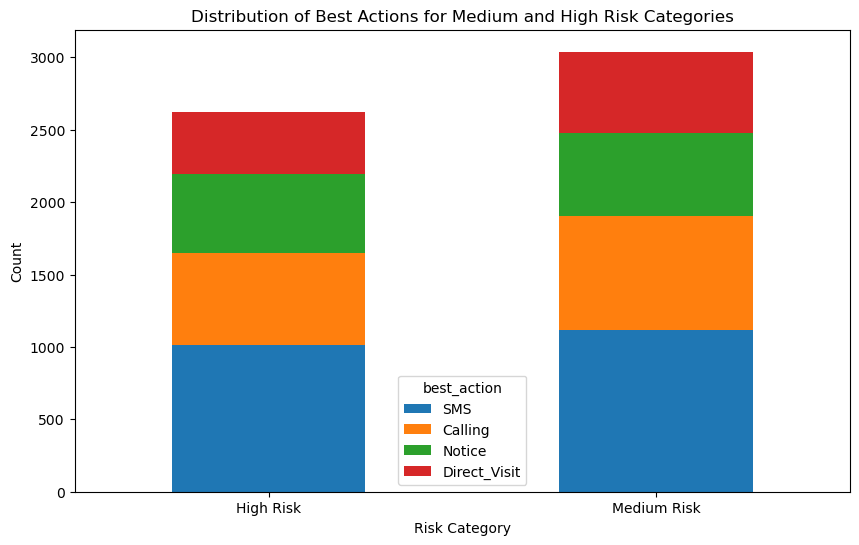

In [16]:
print("\033[1m"+"NBA For High and Medium Risk Customers"+"\033[0m")


medium_high_risk_df = final_df[final_df['risk_category'].isin(['Medium Risk', 'High Risk'])]


ctab = pd.crosstab(medium_high_risk_df['risk_category'], medium_high_risk_df['best_action'])


ordered_columns = ['SMS', 'Calling', 'Notice', 'Direct_Visit']
ctab = ctab[ordered_columns]

# stacked bar chart
ctab.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Distribution of Best Actions for Medium and High Risk Categories')
plt.xlabel('Risk Category')
plt.ylabel('Count')
plt.xticks(rotation=0)  
plt.show()

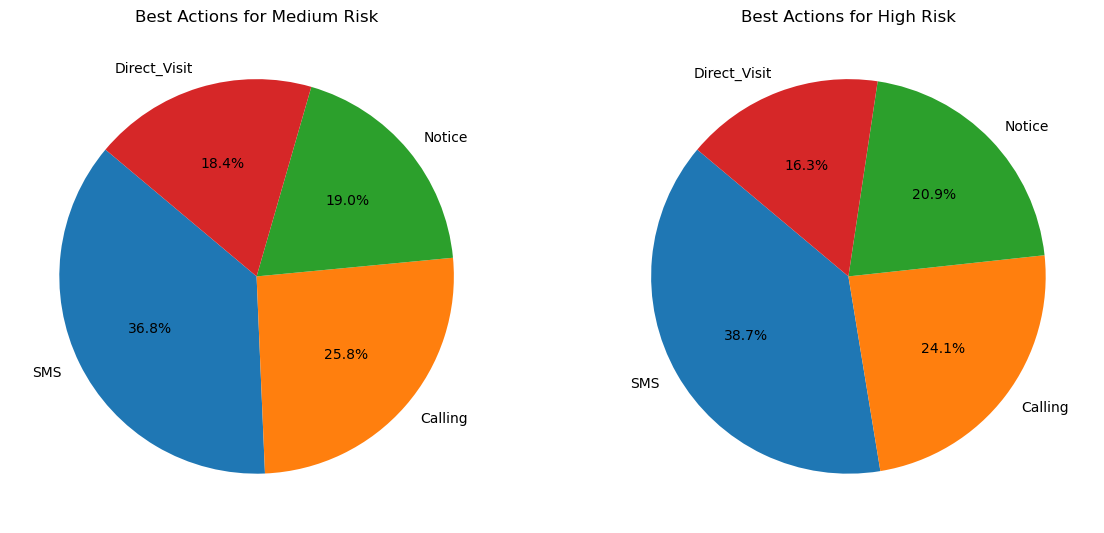

In [17]:
medium_risk_df = final_df[final_df['risk_category'] == 'Medium Risk']
high_risk_df = final_df[final_df['risk_category'] == 'High Risk']


medium_risk_action_counts = medium_risk_df['best_action'].value_counts()
high_risk_action_counts = high_risk_df['best_action'].value_counts()


fig, ax = plt.subplots(1, 2, figsize=(14, 7))


ax[0].pie(medium_risk_action_counts, labels=medium_risk_action_counts.index, autopct='%1.1f%%', startangle=140)
ax[0].set_title('Best Actions for Medium Risk')


ax[1].pie(high_risk_action_counts, labels=high_risk_action_counts.index, autopct='%1.1f%%', startangle=140)
ax[1].set_title('Best Actions for High Risk')


plt.show()

final_df.to_csv('final_oms_data.csv')

In [18]:


df=final_df[final_df['risk_category'].isin(['High Risk', 'Medium Risk'])]



In [19]:
df=df.copy()


df['zone'] = np.random.choice(['North', 'South', 'East', 'West'], size=len(df))


manpower_requirements = {
    'SMS': 0.05,  
    'Calling': 0.50,
    'Notice': 1.5,
    'Direct_Visit': 3
}


df['manpower_required'] = df.apply(lambda row: manpower_requirements[row['best_action']], axis=1)
original_manpower_by_zone = df.groupby('zone')['manpower_required'].sum()
print(original_manpower_by_zone)


zone
East     1360.40
North    1348.00
South    1328.85
West     1418.85
Name: manpower_required, dtype: float64


In [20]:
df.to_csv('final_oms_data.csv')